In [521]:
# Import libraries and dependencies
import pandas as pd
from pathlib import Path
import numpy as np
import hvplot.pandas  # noqa
import hvplot.dask  # noqa
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

In [522]:
# Read CSV, parse dates, and set index
csvpath = Path('./Resources/GHG_Econ_Can_Prov_Terr.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Year', infer_datetime_format=True)
df.head()

,Region,Index,Source,Category,Sub-category,Sub-sub-category,Total,CO2eq,Unit
Year,,,,,,,,,
1990-01-01,Alberta,0,Provincial Inventory Total,NaN,NaN,NaN,y,171.7849588,Mt
1990-01-01,Alberta,1,Oil and Gas,NaN,NaN,NaN,y,65.21309573,Mt
1990-01-01,Alberta,2,Oil and Gas,Upstream Oil and Gas,NaN,NaN,y,61.57702554,Mt
1990-01-01,Alberta,3,Oil and Gas,Upstream Oil and Gas,Natural Gas Production and Processing,NaN,NaN,27.83228536,Mt
1990-01-01,Alberta,4,Oil and Gas,Upstream Oil and Gas,Conventional Oil Production,NaN,y,15.26101044,Mt


## Know more about the data file

In [523]:
df['Source']

Year
1990-01-01    Provincial Inventory Total
1990-01-01                   Oil and Gas
1990-01-01                   Oil and Gas
1990-01-01                   Oil and Gas
1990-01-01                   Oil and Gas
                         ...            
2019-01-01                     Buildings
2019-01-01                     Buildings
2019-01-01                         Waste
2019-01-01                         Waste
2019-01-01                         Waste
Name: Source, Length: 16825, dtype: object

In [524]:
# Get provincal data
total_provincal_ghg = df[df['Source'] == 'Provincial Inventory Total']
total_provincal_ghg.drop(columns=['Index', 'Source','Category','Sub-category','Sub-sub-category', 'Total','Unit'], inplace=True)

# Get Canada data
total_canada_ghg = df[df['Source'] == 'National Inventory Total']
total_canada_ghg.drop(columns=['Index', 'Source','Category','Sub-category','Sub-sub-category', 'Total','Unit'], inplace=True)

# Get Industries data for whole canada
total_industries_ghg = df[df['Region'] == 'Canada'] 
total_industries_ghg = total_industries_ghg[total_industries_ghg['Source'] != 'National Inventory Total']
#total_industries_ghg = df[df['Source'] != 'Provincial Inventory Total']
#total_industries_ghg = df[df['Source'] != 'Territorial Inventory Total']
total_industries_ghg.drop(columns=['Index', 'Region', 'Sub-category', 'Sub-sub-category', 'Total', 'Unit'], inplace=True)

In [525]:
total_provincal_ghg.head()

,Region,CO2eq
Year,,
1990-01-01,Alberta,171.7849588
1991-01-01,Alberta,172.9444695
1992-01-01,Alberta,180.9919743
1993-01-01,Alberta,186.7214107
1994-01-01,Alberta,196.1613682


In [526]:
total_canada_ghg.head()

,Region,CO2eq
Year,,
1990-01-01,Canada,601.5236931
1991-01-01,Canada,595.7767263
1992-01-01,Canada,613.5906402
1993-01-01,Canada,616.7983943
1994-01-01,Canada,638.0004703


In [527]:
total_industries_ghg.head()

,Source,Category,CO2eq
Year,,,
1990-01-01,Waste,NaN,26.00389529
1990-01-01,Waste,Solid Waste,24.90455173
1990-01-01,Waste,Wastewater,0.827491979
1990-01-01,Waste,Waste Incineration,0.271851581
1990-01-01,Agriculture,NaN,57.48296374


In [528]:
region_names = total_provincal_ghg['Region'].unique()
region_names

array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan'], dtype=object)

In [577]:
# Convert CO2eq into Numerical data 
total_provincal_ghg['CO2eq']= pd.to_numeric(total_provincal_ghg['CO2eq'])
total_canada_ghg['CO2eq']= pd.to_numeric(total_canada_ghg['CO2eq'])
total_industries_ghg['CO2eq']= pd.to_numeric(total_industries_ghg['CO2eq'])

In [578]:
# Visualize ghg annual total by region

total_provincal_ghg.hvplot(groupby='Region')

:DynamicMap   [Region]
   :Curve   [Year]   (CO2eq)

In [579]:
# Visualize total ghg output in Canada and respective contribution by region
total_provincal_ghg.hvplot.area(by='Region')

:NdOverlay   [Region]
   :Area   [Year]   (CO2eq,Baseline)

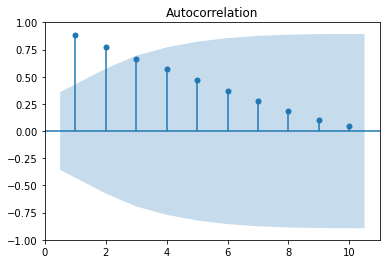

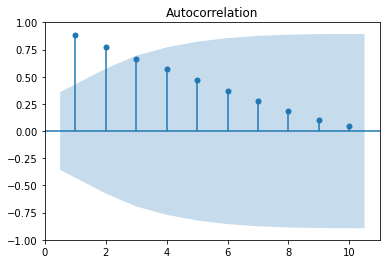

In [580]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = total_provincal_ghg.where(total_provincal_ghg['Region'] == 'Alberta').dropna()
plot_acf(df['CO2eq'], zero=False, lags=10)

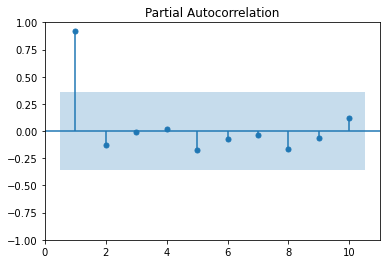

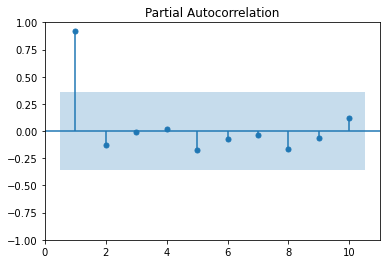

In [581]:
# Plot PACF
plot_pacf(df['CO2eq'], zero=False, lags=10)

## Run ARIMA for AB, BC, ON, and all of Canada

In [582]:
# construct a dataframe with all relevant data
total_ghg = total_canada_ghg.rename(columns={'CO2eq':'Canada'})
total_ghg.drop(columns=['Region'], inplace=True)
total_ghg.head()

,Canada
Year,
1990-01-01,601.523693
1991-01-01,595.776726
1992-01-01,613.590640
1993-01-01,616.798394
1994-01-01,638.000470


In [583]:
region_of_interest = ['Alberta', 'British Columbia', 'Ontario']
# Create dataframe to contain all region of interest
for r in region_of_interest:
    df = total_provincal_ghg.where(total_provincal_ghg['Region'] == r).dropna()
    df.rename(columns={'CO2eq':r}, inplace=True)
    df = df.drop(columns=['Region'])
    total_ghg = pd.concat([total_ghg, df], axis=1)

total_ghg.head()


,Canada,Alberta,British Columbia,Ontario
Year,,,,
1990-01-01,601.523693,171.784959,51.783130,180.048102
1991-01-01,595.776726,172.944469,50.882715,179.469093
1992-01-01,613.590640,180.991974,50.126933,182.898674
1993-01-01,616.798394,186.721411,53.160821,173.161361
1994-01-01,638.000470,196.161368,56.092659,175.479083


In [584]:
import warnings
warnings.filterwarnings("ignore")

In [600]:
# Run ARIMA model of each region
from statsmodels.tsa.arima.model import ARIMA
arima_results = {}
for col in total_ghg.columns:
    # AR look at pacf graph but do not use seasonality peaks
    model = ARIMA(total_ghg[col],  dates=df.index, order=(1, 1, 3))
    # Fit the model
    arima_results.update({col : ARIMA.fit(model)})
    # order is (AR, I, MA)


In [601]:
# Display model summary
summary = {}
for key in arima_results.keys():
    print(f'\nARIMA result smmary for : {key}')
    summary.update({key: arima_results[key].summary()})
    print(summary[key].as_text())


ARIMA result smmary for : Canada
                               SARIMAX Results                                
Dep. Variable:                 Canada   No. Observations:                   30
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -116.879
Date:                Wed, 08 Dec 2021   AIC                            243.758
Time:                        17:00:27   BIC                            250.594
Sample:                    01-01-1990   HQIC                           245.899
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8037      0.262      3.070      0.002       0.291       1.317
ma.L1         -0.6627      0.341     -1.941      0.052      -1.332       0.006
ma.L2         -0.3

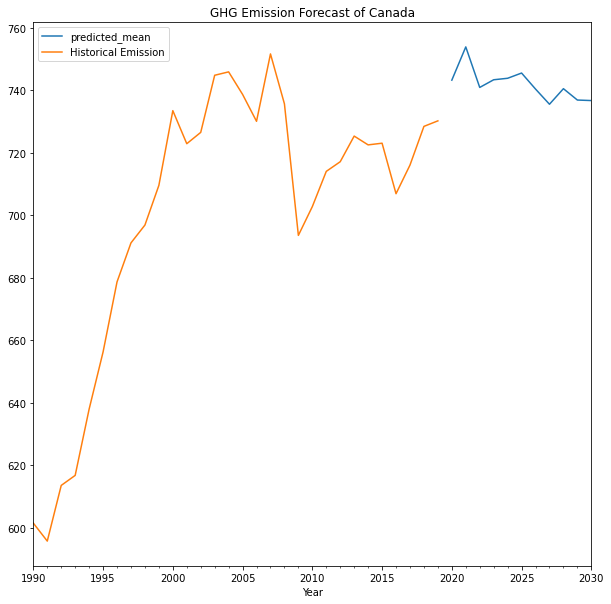

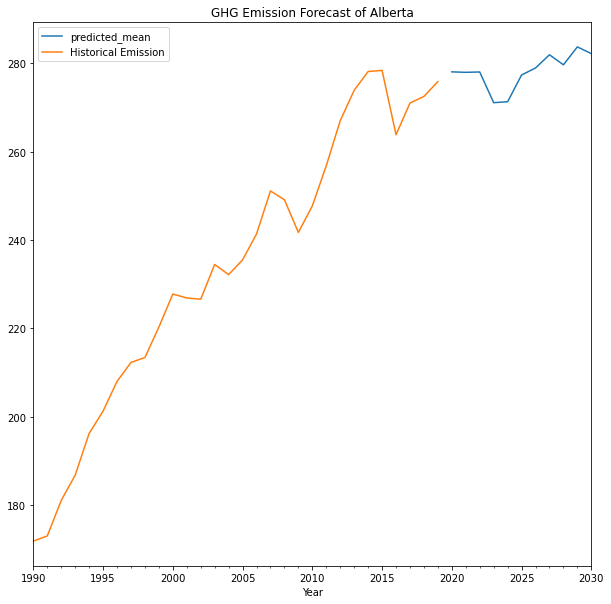

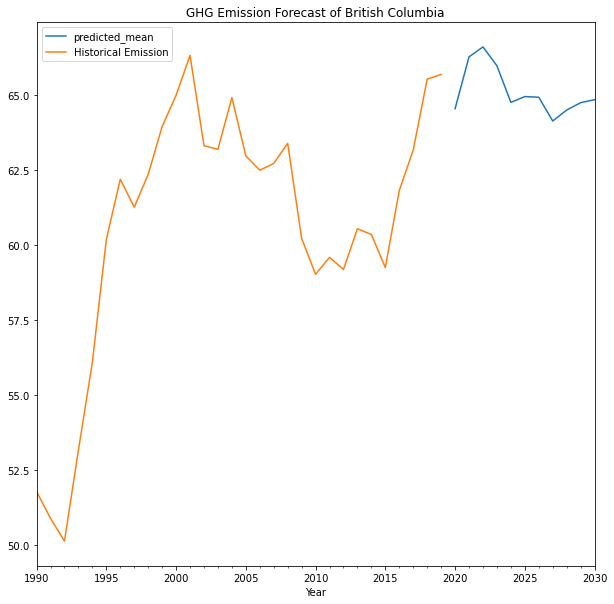

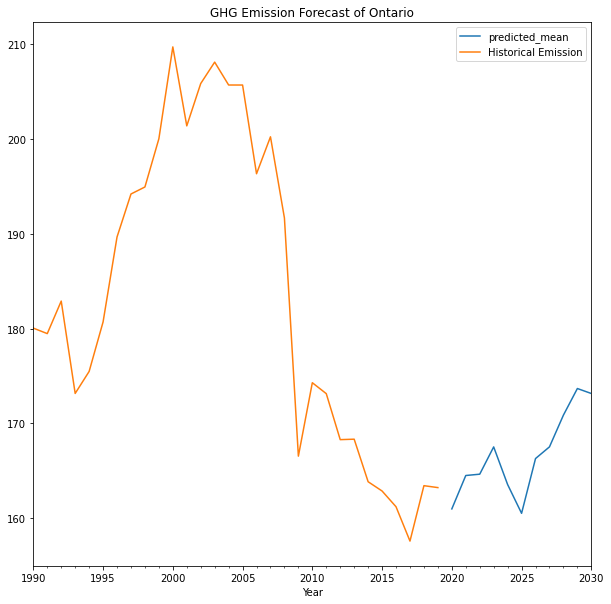

In [587]:
# Visualize the forecast
for key in arima_results:
    forecast_result = pd.DataFrame(arima_results[key].forecast(steps=11))
    forecast_result.plot(title=f'GHG Emission Forecast of {key}', xlabel='Year', label='Predicted Emission').legend()
    total_ghg[key].plot(label='Historical Emission', figsize=(10,10)).legend()
    


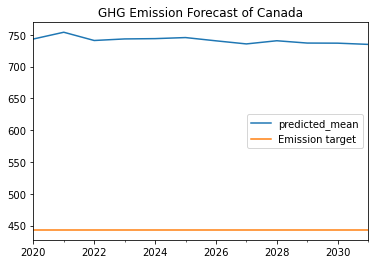

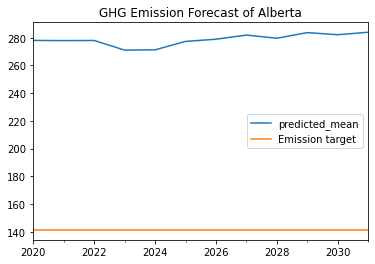

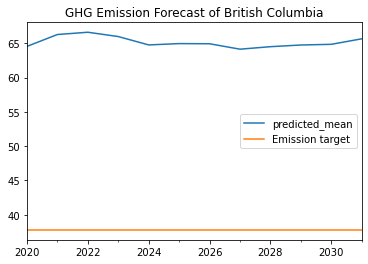

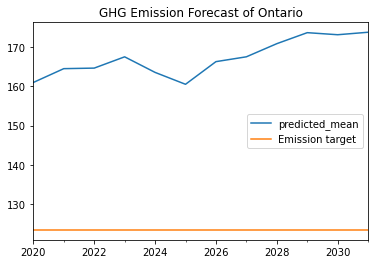

In [589]:
# Visualize result with 2030 target emission
for key in arima_results:
    df = pd.DataFrame(arima_results[key].forecast(steps=12))
    df['Emission target'] = 0.6*total_ghg[key].loc['2005-01-01']
    df.plot(title=f'GHG Emission Forecast of {key}')


## Try to do the forecast using changes each year.
    

In [542]:
total_ghg.head()

,Canada,Alberta,British Columbia,Ontario
Year,,,,
1990-01-01,601.523693,171.784959,51.783130,180.048102
1991-01-01,595.776726,172.944469,50.882715,179.469093
1992-01-01,613.590640,180.991974,50.126933,182.898674
1993-01-01,616.798394,186.721411,53.160821,173.161361
1994-01-01,638.000470,196.161368,56.092659,175.479083


In [543]:
total_ghg_change = total_ghg.pct_change().dropna()
total_ghg_change.head()

,Canada,Alberta,British Columbia,Ontario
Year,,,,
1991-01-01,-0.009554,0.006750,-0.017388,-0.003216
1992-01-01,0.029900,0.046532,-0.014853,0.019110
1993-01-01,0.005228,0.031656,0.060524,-0.053239
1994-01-01,0.034374,0.050556,0.055150,0.013385
1995-01-01,0.028678,0.025802,0.072839,0.029742


In [558]:
# Run the Arima models
arima_results = {}
for col in total_ghg_change.columns:
    # AR look at pacf graph but do not use seasonality peaks
    model = ARIMA(total_ghg_change[col],  dates=df.index, order=(2, 2, 1))
    # Fit the model
    arima_results.update({col : ARIMA.fit(model)})
    # order is (AR, I, MA)


In [559]:
# Display model summary
summary = {}
for key in arima_results.keys():
    print(f'\nARIMA result smmary for : {key}')
    summary.update({key: arima_results[key].summary()})
    print(summary[key].as_text())


ARIMA result smmary for : Canada
                               SARIMAX Results                                
Dep. Variable:                 Canada   No. Observations:                   29
Model:                 ARIMA(2, 2, 1)   Log Likelihood                  62.230
Date:                Wed, 08 Dec 2021   AIC                           -116.459
Time:                        16:12:20   BIC                           -111.276
Sample:                    01-01-1991   HQIC                          -114.918
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5176      0.173     -2.995      0.003      -0.856      -0.179
ar.L2         -0.5030      0.164     -3.075      0.002      -0.824      -0.182
ma.L1         -0.9

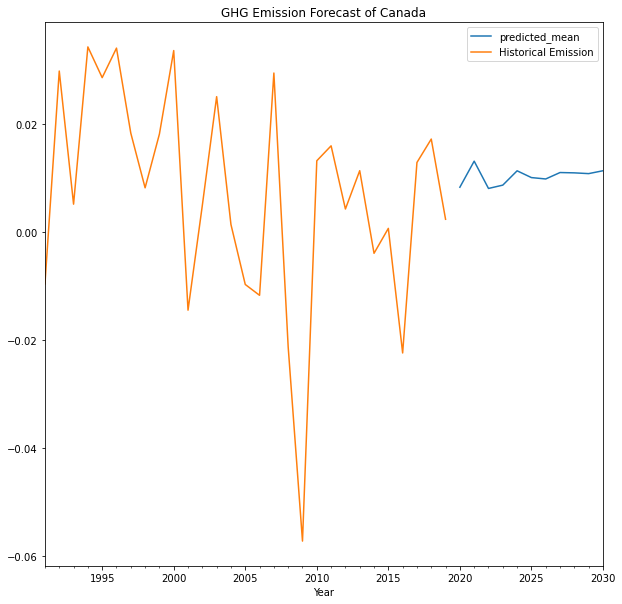

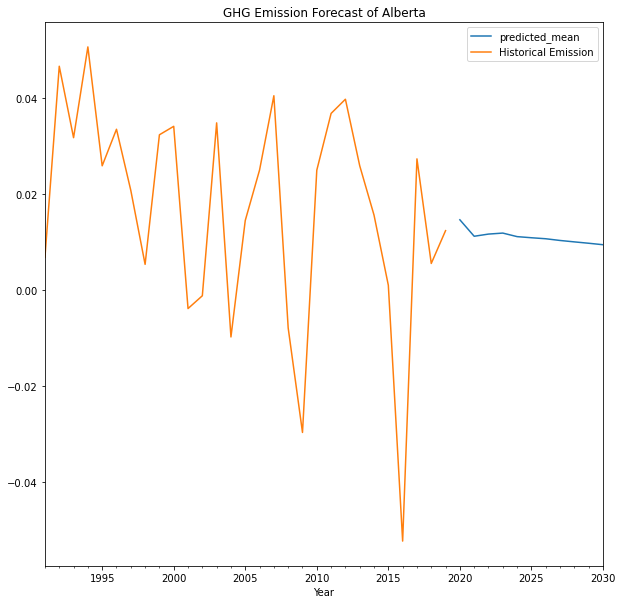

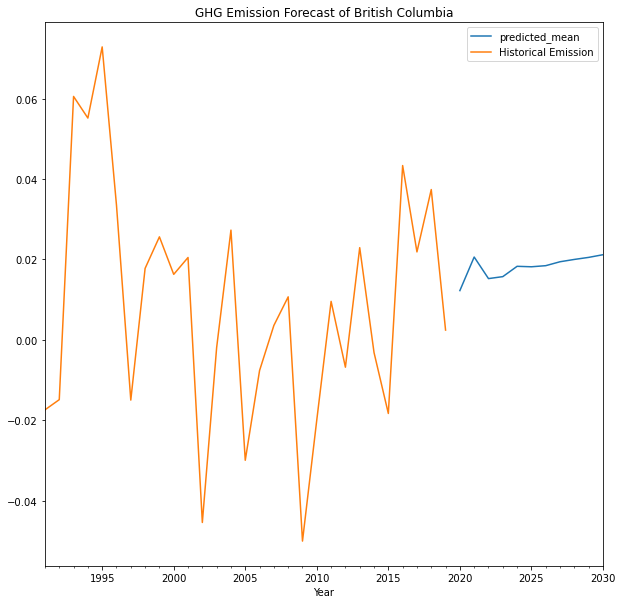

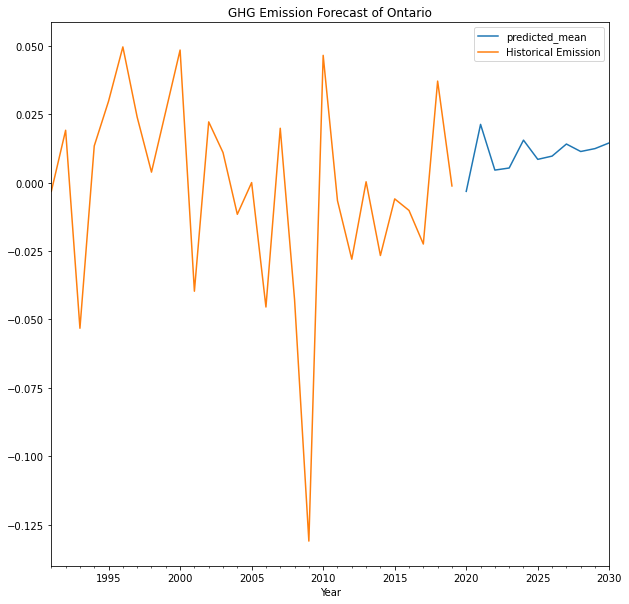

In [560]:
# Visualize the forecast
for key in arima_results:
#    pd.DataFrame(arima_results[key].forecast(steps=12)).plot(title=f'GHG Emission Forecast of {key}')
    forecast_result = pd.DataFrame(arima_results[key].forecast(steps=11))
    forecast_result.plot(title=f'GHG Emission Forecast of {key}', xlabel='Year', label='Predicted Emission').legend()
    total_ghg_change[key].plot(label='Historical Emission', figsize=(10,10)).legend()
    #update the total_ghg dataframe to include the forecasted emissions
    total_ghg[key].loc

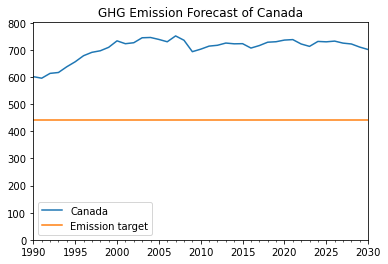

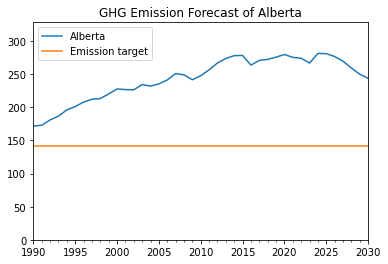

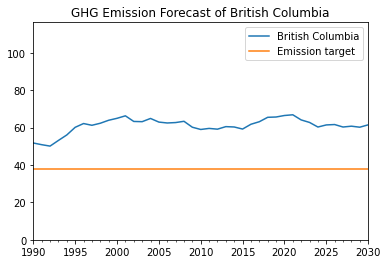

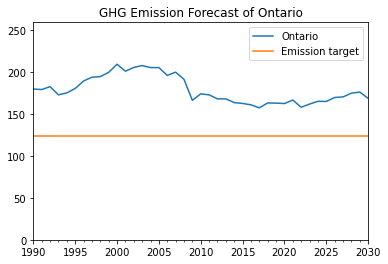

In [561]:
# Visualize result with 2030 target emission
df1 = total_ghg.copy()
for key in arima_results:
    forecast_result = pd.DataFrame(arima_results[key].forecast(steps=11))
    df =  pd.concat([df1[key], forecast_result], axis=1, join = 'outer')
    for i in range(len(forecast_result)):
        x = df['predicted_mean'].iloc[-1*(len(forecast_result))+i]
        y = df[key].iloc[-1*(len(forecast_result)+i+1)]
        df[key].iloc[-1*(len(forecast_result))+i] = y*(1+x)
    df.drop(columns=['predicted_mean'], inplace=True)
    
    df['Emission target'] = 0.6*total_ghg[key].loc['2005-01-01']
    df.plot(title=f'GHG Emission Forecast of {key}', ylim=[0, max(total_ghg[key]+50)])

## Run ARIMA for various industries in Canada

In [562]:
industries_names = total_industries_ghg['Source'].unique()
industries_names

array(['Waste', 'Agriculture', 'Oil and Gas', 'Coal Production',
       'Electricity', 'Transport', 'Heavy Industry',
       'Light Manufacturing, Construction and Forest Resources',
       'Buildings'], dtype=object)

In [563]:
industries_agg = total_industries_ghg[total_industries_ghg['Category'].isna()]

In [564]:
industries_agg.drop(columns=['Category'], inplace=True)

In [565]:
#industries_agg.head()
# Visualize total ghg output in Canada and respective contribution by region
industries_agg.hvplot.area(by='Source', width=1000, height=500)

:NdOverlay   [Source]
   :Area   [Year]   (CO2eq,Baseline)

In [566]:
# Create dataframe to contain all industries of interest
total_ghg = pd.DataFrame()
for i in industries_names:
    df = industries_agg.where(industries_agg['Source'] == i).dropna()
    df.rename(columns={'CO2eq':i}, inplace=True)
    df = df.drop(columns=['Source'])
    total_ghg = pd.concat([total_ghg, df], axis=1)

total_ghg.head()

,Waste,Agriculture,Oil and Gas,Coal Production,Electricity,Transport,Heavy Industry,"Light Manufacturing, Construction and Forest Resources",Buildings
Year,,,,,,,,,
1990-01-01,26.003895,57.482964,102.157574,4.025311,94.720767,120.483489,97.169391,28.216739,71.263564
1991-01-01,27.231226,57.694078,101.962453,4.174209,96.101442,114.317653,97.094652,26.606086,70.594927
1992-01-01,27.855804,59.989218,111.165757,3.539928,102.517985,115.223505,94.532944,26.333378,72.432121
1993-01-01,28.798068,61.954656,118.036597,4.161400,93.124694,116.705817,93.998720,24.034876,75.983564
1994-01-01,29.924030,64.788631,121.901211,4.158365,95.149944,121.332564,99.604421,24.846210,76.295094


In [567]:
# Get the pct change year on year
total_ghg_change = total_ghg.pct_change().dropna()
total_ghg_change.head()

,Waste,Agriculture,Oil and Gas,Coal Production,Electricity,Transport,Heavy Industry,"Light Manufacturing, Construction and Forest Resources",Buildings
Year,,,,,,,,,
1991-01-01,0.047198,0.003673,-0.001910,0.036991,0.014576,-0.051176,-0.000769,-0.057081,-0.009383
1992-01-01,0.022936,0.039781,0.090262,-0.151952,0.066768,0.007924,-0.026384,-0.010250,0.026024
1993-01-01,0.033827,0.032763,0.061807,0.175561,-0.091626,0.012865,-0.005651,-0.087285,0.049031
1994-01-01,0.039099,0.045743,0.032741,-0.000729,0.021748,0.039645,0.059636,0.033757,0.004100
1995-01-01,0.036282,0.048999,0.051369,-0.027434,0.032133,0.006670,0.007052,0.103888,0.009677


In [574]:
# Run the Arima models
arima_results = {}
for col in total_ghg_change.columns:
    # AR look at pacf graph but do not use seasonality peaks
    model = ARIMA(total_ghg_change[col],  dates=df.index, order=(2, 2, 1))
    # Fit the model
    arima_results.update({col : ARIMA.fit(model)})
    # order is (AR, I, MA)

In [575]:
# Display model summary
summary = {}
for key in arima_results.keys():
    print(f'\nARIMA result smmary for : {key}')
    summary.update({key: arima_results[key].summary()})
    print(summary[key].as_text())


ARIMA result smmary for : Waste
                               SARIMAX Results                                
Dep. Variable:                  Waste   No. Observations:                   29
Model:                 ARIMA(2, 2, 1)   Log Likelihood                  56.475
Date:                Wed, 08 Dec 2021   AIC                           -104.951
Time:                        16:18:28   BIC                            -99.768
Sample:                    01-01-1991   HQIC                          -103.410
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4063      0.131     -3.098      0.002      -0.663      -0.149
ar.L2         -0.2608      0.181     -1.439      0.150      -0.616       0.095
ma.L1         -0.97

In [576]:
# Visualize result with 2030 target emission
df1 = total_ghg.copy()
df4plot = pd.DataFrame()
for key in arima_results:
    forecast_result = pd.DataFrame(arima_results[key].forecast(steps=11))
    df =  pd.concat([df1[key], forecast_result], axis=1, join = 'outer')
    for i in range(len(forecast_result)):
        x = df['predicted_mean'].iloc[-1*(len(forecast_result))+i]
        y = df[key].iloc[-1*(len(forecast_result)+i+1)]
        df[key].iloc[-1*(len(forecast_result))+i] = y*(1+x)
    df.drop(columns=['predicted_mean'], inplace=True)
    df4plot[key] = df.copy()
    
    #df['Emission target'] = 0.6*total_ghg[key].loc['2005-01-01']
    #df.hvplot(title=f'GHG Emission Forecast of {key}', ylim=[0, max(total_ghg[key]+10)])
df4plot.head()
df4plot.hvplot.area(y=['Oil and Gas','Transport', 'Buildings'], stack=False, alpha=0.4, height = 400)

:NdOverlay   [Variable]
   :Area   [index]   (value,Baseline)